# Measuring Abusiveness by Network Operator

It is often thought of that cybersecurity attacks and abuse happen consistently throughout the Internet. The reality is there is patterns to the infrastructure criminals use to launch their attacks. This becomes important for those setting global security policies (which bad networks do I want to block) or for national regulators who wish to identify which networks are problematic in their own countries for regulatory purposes. By analyzing the prevalence of a given providers infrastructure being used for abuse, it becomes possible to see who the worst offenders are.

The methodology for this approach is to take abuse feeds from a commercial vendor used to block bad internet traffic. This data is already curated and produce for the purposes of identifying bad traffic. Providers, however, have many customers and a variable amount of infrastructure they use to service those customers. The interactive graph takes network providers and shows the Top 50 worst providers (ASN) in a particular country. An ASN (Autonomous System Number) is a unique identifier for a specific organization so they can announce blocks of IP addresses that can be reached on the Internet. An ASN will have a variable number of IPs assigned to it, some as few as 255, some could have several hundred thousand. By calculating the percentage of IP addresses marked bad as a factor of the total number of IP addresses a provider has, it gives a good baseline as to whom those network providers are who cater to criminality.

The intent is to mathematically identify internet "bad neighborhoods" for the purposes of proactively blocking them, for governments to put pressure on them to clean up, and for other network operators to treat their information with suspicion.

In [20]:
import plotly
import datetime
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.plotly as py
import matplotlib.pyplot as plt
from IPython.display import Image

from ipywidgets import widgets

# Measuring Abuse by Top-Level Domain

Domain names (i.e. google.com, illinois.edu) are often used in abuse for the same reason we use domains to access websites, it makes identifying network locations accessible to human beings. A Top-Level-Domain is the last portion of a hostname, so for google.com, the top-level domain is .com. For illinois.edu it is .edu.  There are top-level domains that correspond to country codes (.us, .ru, .uk) and "generic" top-level domains like .com, .net, .ninja and so on. The below graphic shows the overall DNS hierarchy to better illustrate how this works together.

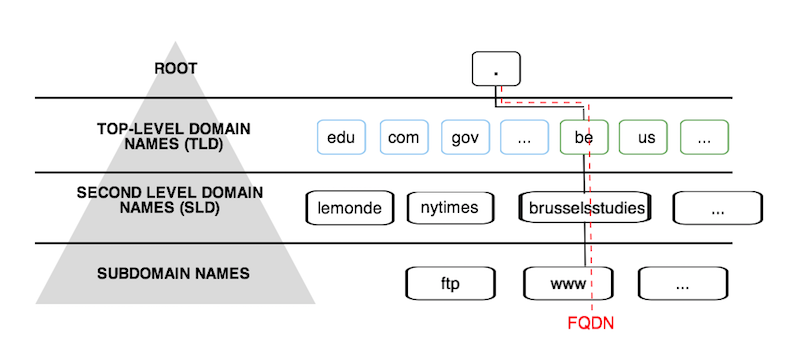

In [22]:
# Source: https://www.researchgate.net/profile/Simon_Hengchen/publication/303969972/figure/fig1/AS:373152539529223@1465977906830/DNS-Hierarchy.png
Image(filename='DNS-Hierarchy.png') 

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



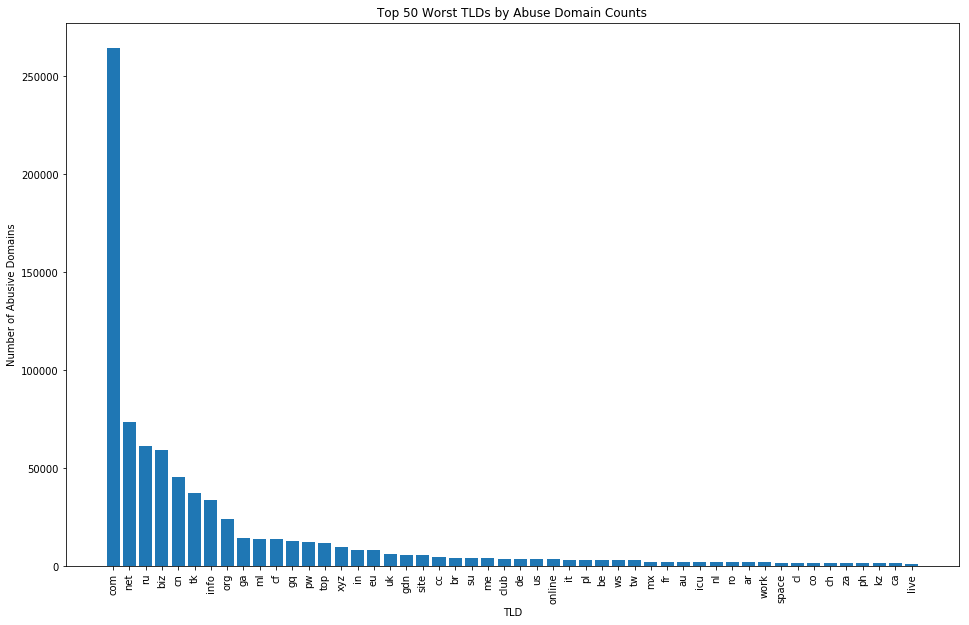

In [16]:
tld = pd.read_csv("merged-tld.csv")
filter0 = tld['TotalDomainCount'] >= 200
filter1 = tld['abusePercent'] <= 1
firstfilter = tld[filter0]
finaltld = firstfilter[filter1]
firsttld = finaltld.nlargest(50, 'AbuseDomains')
secondtld = finaltld.nlargest(50, 'abusePercent')
plt.figure(figsize=(16,10))
plt.bar(firsttld['TLD'], firsttld['AbuseDomains'])
plt.xticks(firsttld['TLD'], rotation='vertical')
plt.ylabel('Number of Abusive Domains')
plt.xlabel('TLD')
plt.title('Top 50 Worst TLDs by Abuse Domain Counts')
plt.show()

### Counting abuse by total number of abuse domains

As you can see, .com appears to be the biggest offender. But that should not be unexpected because .com represents the largest (by far) top level domain around the world.  A better approach would be to see what the percentage of domains in a given TLD are abusive and then to figure out why criminals are congregating to specific TLDs.

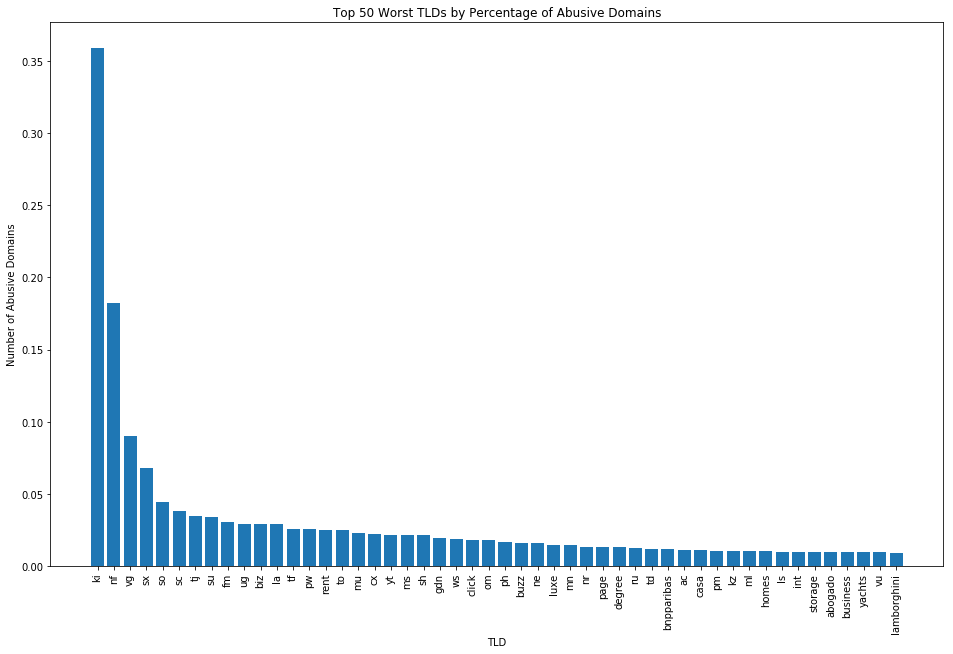

In [18]:
plt.figure(figsize=(16,10))
plt.bar(secondtld['TLD'], secondtld['abusePercent'])
plt.xticks(secondtld['TLD'], rotation='vertical')
plt.ylabel('Number of Abusive Domains')
plt.xlabel('TLD')
plt.title('Top 50 Worst TLDs by Percentage of Abusive Domains')
plt.show()

### Measuring by abuse percentage

As you can see, the results are very different where .com is no longer visible. The most abused TLD is .ki which is the Top-Level Domain for Kiribati, a small island nation in the Pacific. What is also interresting is the very rapid drop-off when considering abuse percentages. Simply put, looking at the data this way with this data set did not adequately identify specific Top-Level Domains that could be considered highly abusive.

In [4]:
asndf = pd.read_csv(
    'abuse-with-asn-and-geo.csv')
ccdf = pd.read_csv('asn-cc-mapping.csv', sep="|")

ccdf = ccdf.drop(columns=['CC'])

df = asndf.merge(ccdf, on='ASN')

df['ASN'] = df['ASN'].astype(str)
df = df.sort_values(by=['abusePercent'])

countries = list(df['CC'].unique())
countries.sort()
countries.insert(0, "All")

origin = widgets.Dropdown(
    options=countries,
    value='All',
    description='Country Code:',
)


firstdf = df.nlargest(50, 'abusePercent')
# Assign an emptry figure widget with two traces
trace1 = go.Bar(x=firstdf['ASN'].astype(str), y=firstdf['abusePercent'])

layout = go.Layout(
                        title=dict(
                            text='Top 50 ASNs by Abuse Percentage'
                        ),
                        xaxis=dict(
                            type="category",
                            title='AS Number'
                        ),
                        yaxis=dict(
                            title='% of Abusive IPs',
                            categoryorder = "category ascending"
                        ),
                        barmode='overlay'
                    )

tabletrace = go.Table(
    header=dict(values=list(['ASN', 'AS Name']),
                fill = dict(color='#C2D4FF'),
                align = ['left'] * 5),
    cells=dict(values=[firstdf.ASN, firstdf.AS_Name],
               fill = dict(color='#F5F8FF'),
               align = ['left'] * 5))

layout2 = go.Layout(
                        title=dict(
                            text='ASN to AS Name Mapping'
                        ))

g = go.FigureWidget(data=[trace1], layout=layout)
h = go.FigureWidget(data=[tabletrace], layout=layout2)

def validate():
    if origin.value in df['CC'].unique():
        return True
    if origin.value == "All":
        return True
    else:
        return False


def response(change):
    if validate():
        if origin.value == "All":
            temp_df = df
        else:
            filter_list = df['CC'] == origin.value
            temp_df = df[filter_list]
        top50df = temp_df.nlargest(50, 'abusePercent')
        x1 = top50df['ASN'].astype(str)
        y1 = top50df['abusePercent']
        z1 = top50df['AS_Name']
 
#        bar = g.data[0]
#        bar.x = x1
#        bar.y = y1
        
        table = h.data[0]
        table = [x1, z1]
        with g.batch_update():
            g.data[0].x = x1
            g.data[0].y = y1

        with h.batch_update():
            h.data[0].cells.values = [top50df.ASN, top50df.AS_Name]
            
        g.layout = layout

origin.observe(response, names="value")


## Relationship to IP address and Autonomous System Number

Network operators may have many different and non-contiguous IP addresses going to the same location. For instance, AS38 corresponds to the University of Illinois. The following are netblocks that are routed to this campus:

72.36.64.0/18    
72.36.80.0/23    
72.36.84.0/22    
72.36.88.0/24    
72.36.96.0/20
72.36.96.0/24    
72.36.100.0/22   
72.36.104.0/21   
128.174.0.0/16   
130.126.0.0/16   
192.17.0.0/16  

Since we want to measure abusiveness of a specific network operator, we need to take a step above the chain from IP address to ASN. The dataset we are using here already has been post-processed to contain ASN abuse rates as derived from IP abuse data. Below is an illustration of the relationship of AS Number and IP address.

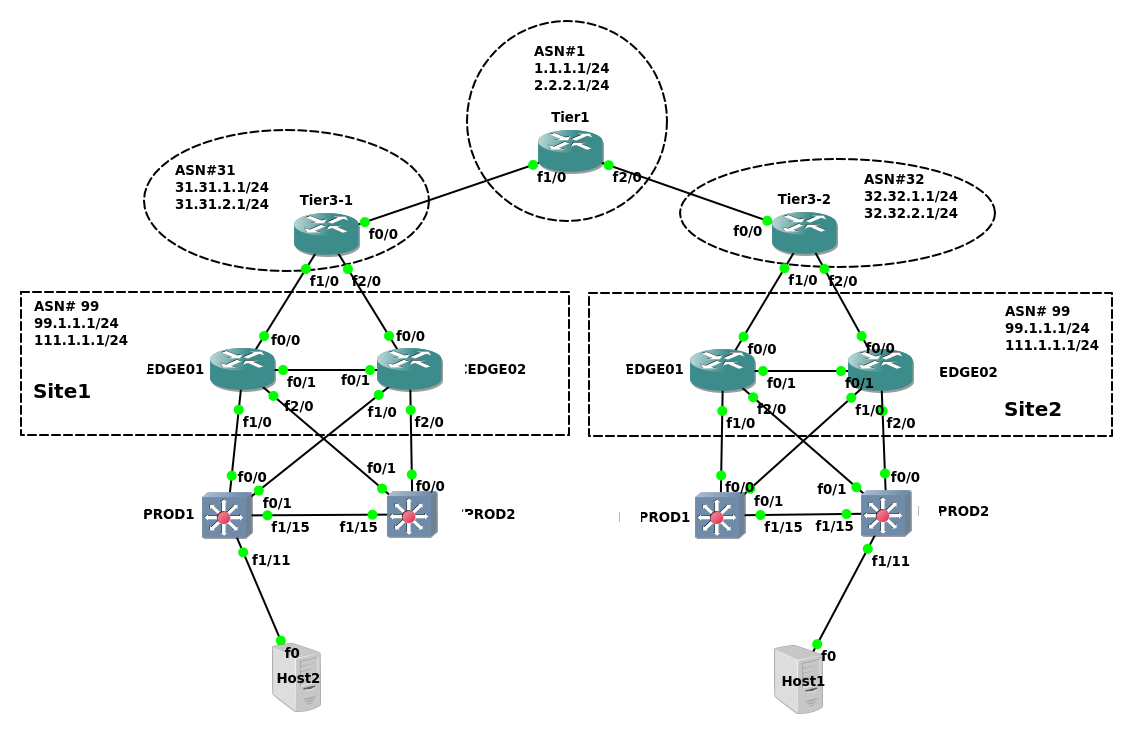

In [23]:
# Image from: https://i.stack.imgur.com/JlfOg.png
Image('ASN.png')

# Main Interactive Visualization - Worst Offenders by Country

Below you can select a specific country by ISO country code (US - United States, RU - Russia, VA - Vatican City, etc) to see the top 50 worst network providers. In some cases, there may not be 50 network providers in a country. In some cases, all the networks in a country are essentially "clean" so the height of the bars will auto-scale. Included below the bar chart is a table that converts the AS Number to the name as stored in the registry for that region that should map to an organization name. 

In [5]:
container2 = widgets.HBox([origin])
widgets.VBox([container2,
              g, h])